In [33]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

In [34]:
df = pd.read_csv("data/ai4i2020.csv")


In [35]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Drop Leakage Columns

❗ These columns reveal failure type and indirectly the target:

In [36]:
leakage_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df.drop(columns=leakage_cols, inplace=True)

In [37]:
df.drop(columns='Product ID',inplace=True)

Encode Categorical Feature (Product Type)
Encoding:

L → 0

M → 1

H → 2

In [38]:
le = LabelEncoder()
df['Type']=le.fit_transform(df['Type'])

In [39]:
df.head()

,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,1,2,298.1,308.6,1551,42.8,0,0
1,2,1,298.2,308.7,1408,46.3,3,0
2,3,1,298.1,308.5,1498,49.4,5,0
3,4,1,298.2,308.6,1433,39.5,7,0
4,5,1,298.2,308.7,1408,40.0,9,0


Define Features and Target

In [40]:
X = df.drop('Machine failure', axis=1)
y = df['Machine failure']

Train-Test Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#I used stratified splitting to ensure the minority failure class is equally represented in both training and test sets, preventing biased evaluation.

Handle Class Imbalance using SMOTE ⚖️

In [42]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Feature Scaling

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)
#Scaling was applied after SMOTE to avoid data leakage and ensure distance-based algorithms perform optimally.

Model 1: Logistic Regression

In [44]:
lr = LogisticRegression()
lr.fit(X_train_scaled,y_train_res)
y_pred_lr = lr.predict(X_test_scaled)

print("Accuracy : ", accuracy_score(y_test,y_pred_lr))
print(classification_report(y_test,y_pred_lr))

Accuracy :  0.852
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      1932
           1       0.16      0.78      0.26        68

    accuracy                           0.85      2000
   macro avg       0.57      0.82      0.59      2000
weighted avg       0.96      0.85      0.90      2000



Model 2 : Decision Tree

In [45]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res, y_train_res)


y_pred_dt = dt.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Accuracy: 0.939
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1932
           1       0.31      0.63      0.41        68

    accuracy                           0.94      2000
   macro avg       0.65      0.79      0.69      2000
weighted avg       0.96      0.94      0.95      2000



Model 3: Random Forest

In [46]:
rf = RandomForestClassifier(
n_estimators=100,
random_state=42,
class_weight='balanced'
)


rf.fit(X_train_res, y_train_res)


y_pred_rf = rf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.956
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.42      0.74      0.53        68

    accuracy                           0.96      2000
   macro avg       0.70      0.85      0.75      2000
weighted avg       0.97      0.96      0.96      2000



In [47]:


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

grid = GridSearchCV(
    rf,
    param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_res, y_train_res)

best_model = grid.best_estimator_


In [48]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.42      0.74      0.53        68

    accuracy                           0.96      2000
   macro avg       0.71      0.85      0.76      2000
weighted avg       0.97      0.96      0.96      2000

ROC-AUC: 0.9573590305687492


Confusion Matrix Visualization

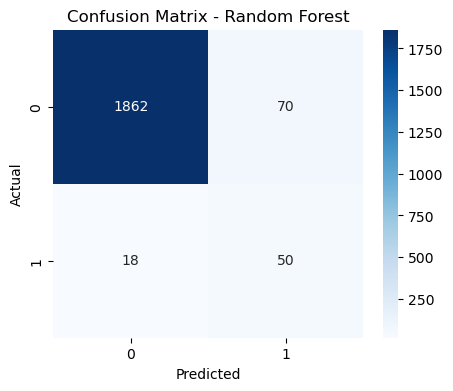

In [49]:
cm = confusion_matrix(y_test, y_pred_rf)


plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()
#“Confusion matrix helps identify false negatives, which are critical in predictive maintenance."

ROC–AUC Curve

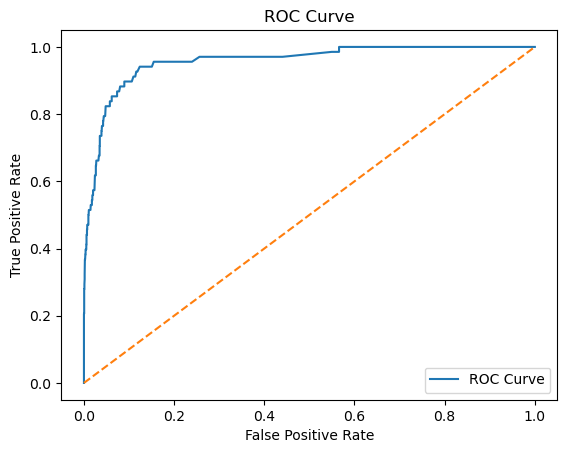

In [50]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Precision–Recall Curve (IMPORTANT for Imbalance)

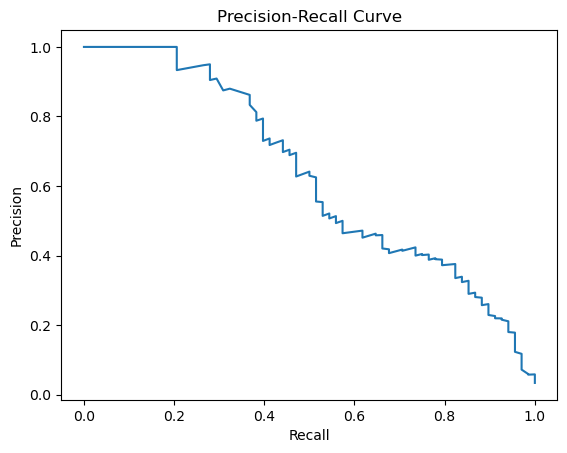

In [52]:

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()
#Precision–Recall curves are more informative than ROC when dealing with imbalanced datasets

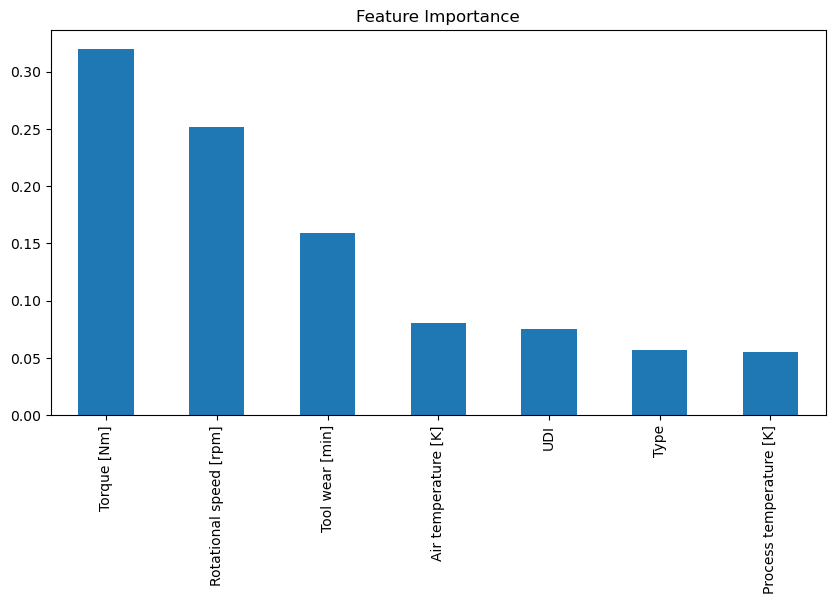

In [51]:
importance = best_model.feature_importances_

feat_imp = pd.Series(importance, index=X.columns).sort_values(ascending=False)

feat_imp.plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance")
plt.show()